<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [69]:
import re
import string
# This is for removing html tags
from bs4 import BeautifulSoup
# For instructors function to count tokens/words
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
# OG imports 8)
import pandas as pd
import numpy as np
import spacy

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [26]:
##### Your Code Here #####
raise Exception("\nThis task is not complete. \nReplace this line with your code for the task."

SyntaxError: unexpected EOF while parsing (<ipython-input-26-9cfb6145a733>, line 2)

## 2) Use Spacy to tokenize / clean the listings 

Read in teh data

In [27]:
nlp = spacy.load("en_core_web_lg")

In [112]:
df = pd.read_csv('./data/job_listings.csv', index_col=0)
df.head(3)

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level


In [113]:
df.shape

(426, 2)

Use spaCy to tokenize and clean listings. Could destory those html tags everywhere but idk, doesn't seem like it matters if I do...

In [114]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_t = soup.get_text(separator=" ")
    return stripped_t

df['desc_clean'] = df['description'].apply(strip_html)
# Regex kindly provided by Harsh, thx bud
df['desc_clean'] = df['desc_clean'].str.replace(r'\\(x|n)[a-z0-9]{0,2}', ' ')

In [115]:
df.head(2)

,description,title,desc_clean
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b"" Job Requirements: Conceptual understanding..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b' Job Description As a Data Scientist 1, ..."


In [116]:
### Apply this function using .apply to the whole column
STOPPIES = nlp.Defaults.stop_words.union([
    'it','the', 'b\'', 'b\"', '\\n', 'b',
    'place', 'come', '$', '+', ' '])
def lemma(text):
    """
    Runs the sentence through the nlp object declared all the way up there.
    Then takes that and removes all the junk we don't need and puts into
    a neat new column
    """
    # declared lemmas array
    lemmas = []
    # Send the review text to the NLP pipeline
    outy = nlp(text)
    for token in outy:
        # Check if stop word, punctuation, or if it's a PRON which I forgot...what exactly that is
        # I think token.is_stop == False and the not in STOPPIES is redundant, true?
        if ((token.is_stop == False) and (token.text not in STOPPIES) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    return lemmas
df['desc_token'] = df['desc_clean'].apply(lemma)

In [117]:
df.head(5)

,description,title,desc_clean,desc_token
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b"" Job Requirements: Conceptual understanding...","[job, requirement, conceptual, understanding, ..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b' Job Description As a Data Scientist 1, ...","[job, description, , Data, Scientist, 1, h..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b' As a Data Scientist you will be working on ...,"[Data, scientist, work, consult, business, res..."
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b' $4,969 - $6,756 a month Contract Under the ...","[4,969, 6,756, month, Contract, general, super..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b' Location: USA multiple locations 2+ y...,"[location, USA, , multiple, location, , ..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

dtm is document term matrix

In [118]:
# CountVectorizer to each desc_clean I guess, and then put into dataframe
data = list(df.desc_clean)
v = CountVectorizer(stop_words=STOPPIES, min_df=0.05, max_df=0.90,lowercase=True)
v.fit(data)
v_dtm = v.transform(data)
dtm1 = pd.DataFrame(v_dtm.todense(), columns=v.get_feature_names())

/home/ygeun/anaconda3/envs/U4W1-NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [119]:
dtm1.head(5)

,000,10,100,2019,40,abilities,ability,able,academic,access,...,workplace,works,world,write,writing,written,www,year,years,york
0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,2,0,2,1,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Let's try TF-IDF

In [120]:
# Teacher's function
def tokenize(document):
    doc = nlp(document)
    return [token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)]

tfidf = TfidfVectorizer(tokenizer=tokenize, min_df=0.25, max_df=0.95, ngram_range=(1,2))
# Create vocab/get words per doc by learning vocab and transforming data into wanted form
out = tfidf.fit_transform(data)
# Put into dataframe
dtm2 = pd.DataFrame(out.todense(), columns=tfidf.get_feature_names())

In [121]:
dtm2.head(5)

,,,,,,experience,s,experience,work,+,...,value,veteran,veteran status,visualization,way,work,world,write,year,year experience
0,0.263181,0.458772,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.078097,0.000000,0.136267,0.000000,0.0
1,0.798243,0.089198,0.040063,0.179269,0.0,0.0,0.050953,0.070012,0.038699,0.032287,...,0.0,0.000000,0.00000,0.0,0.072721,0.109326,0.056749,0.095379,0.021743,0.0
2,0.418128,0.000000,0.081843,0.000000,0.0,0.0,0.000000,0.143026,0.000000,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.148892,0.000000,0.000000,0.000000,0.0
3,0.277725,0.060516,0.135903,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.116393,0.13178,0.0,0.000000,0.123619,0.000000,0.000000,0.073759,0.0
4,0.000000,0.494568,0.000000,0.177496,0.0,0.0,0.000000,0.000000,0.000000,0.223774,...,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.150699,0.0


Positively disgusting if I turned the min_df too low, wow. Tried using BeautifulSoup to clean up the HTML beforehand but it was still really ugly. Turning the min_df up removes a lot of hex codes littered about but of course the columns are now reduced to a paltry 188.

## 4) Visualize the most common word counts

In [122]:
### Instructor's Function
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')
wc = count(df['desc_token'])

In [123]:
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
60,,394,4472,1.0,0.031586,0.031586,0.924883
27,datum,409,2921,2.0,0.020631,0.052217,0.960094
81,experience,410,1950,3.0,0.013773,0.065990,0.962441
66,work,385,1627,4.0,0.011491,0.077481,0.903756
104,,342,1575,5.0,0.011124,0.088605,0.802817
244,team,364,1312,6.0,0.009267,0.097872,0.854460
310,business,322,1188,7.0,0.008391,0.106263,0.755869
270,Data,331,854,8.0,0.006032,0.112295,0.776995
107,product,270,821,9.0,0.005799,0.118093,0.633803
39,model,274,820,10.0,0.005792,0.123885,0.643192


#### use good ole' squarify to see common words in a pretty way

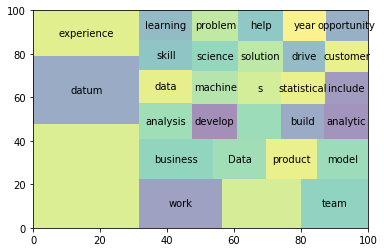

In [124]:
squarify.plot(sizes=wc.iloc[:30]['pct_total'], label=wc['word'],alpha=.5);

#### Could also separate by title, so maybe group senior positions and beginner positions and see the diff

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

### Look at the third question, I did this already

## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [125]:
# Fit nearest neighbours onto the TF-IDF dataframe
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm2)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [126]:
# Query
nn.kneighbors([dtm2.iloc[100]])

(array([[0.        , 0.        , 0.84990509, 0.88858531, 0.89277913]]),
 array([[ 47, 100, 287, 341, 185]]))

In [127]:
data[150][:100]

"b' Contract 1 year+ contract   Data Scientist     contract   Early Clinical Development (ECD) depart"

In [128]:
# Example best job example
example = ["""
Well, we need someone smart, smart and very cool. My god, we may even need someone with an extreme
propensity for doing the right thing...yeah, that's what we really need, someone with a conscience!
"""] # Needs to be a string in a list or tfidf screams

new = tfidf.transform(example)

a = nn.kneighbors(new.todense())

In [129]:
def read_results(arr):
    arr_in = arr[1][0]
    x = 1
    for n in arr_in:
        print(f'{x}: {data[n][:200]}\n')
        x+=1

In [130]:
read_results(a)

1: b' Data Scientist  Email at hr@dataxpander.com   They need to have statistical, mathematical, predictive modelling as well as business strategy skills to build the algorithms necessary to ask the righ

2: b' There   s a lot of work around Osmo for someone with a love of statistics.    For one there   s anonymous player statistics that need to be distilled into understanding of what works and doesn   t 

3: b" You will collaborate with the brightest technical minds in building futuristic products, researching groundbreaking concepts, and influencing new ideas to transform retail. If you want to make mean

4: b" You will collaborate with the brightest technical minds in building futuristic products, researching groundbreaking concepts, and influencing new ideas to transform retail. If you want to make mean

5: b" You will collaborate with the brightest technical minds in building futuristic products, researching groundbreaking concepts, and influencing new ideas to transform retail. I

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 